In [1]:
# try to train CNN to classify different stages
# coding: utf-8

import numpy as np
import pandas as pd
import time, os, sys, glob, io
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy

mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 22})
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [31]:
now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
RANDOM_SEED = 42
PATH = os.getcwd()

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [32]:
LOGFILE = os.path.join(PATH, now + '_training.log')

# Logging

header = []

# header.append('Current Time: %s' % now)
header.append('PyTorch Version: %s' % torch.__version__)
header.append('CUDA device available: %s' % torch.cuda.is_available())
header.append('Using CUDA device: %s' % device)
header.append('Random Seed: %s' % RANDOM_SEED)
header.append('Output Path: %s' % PATH)


with open(LOGFILE, 'w') as f:
    for entry in header:
        print(entry)
        f.write('%s\n' % entry)
        f.flush()

PyTorch Version: 1.7.1
CUDA device available: True
Using CUDA device: cuda:0
Random Seed: 42
Output Path: C:\Users\AChub_Lab\Desktop\my_project


In [4]:
def add2log(s):
    try:
        with io.open(LOGFILE, "a", encoding="utf-8") as f:
            f.write('%s\n' % s)
    except:
        print("not logged")

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
# load data
path = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\train"
matches = []
for root, dirnames, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith(('.png')) and "cp" not in filename:
#             print (filename)
            matches.append(os.path.join(root, filename))
print (len(matches))

3978


In [14]:
class_name = {"uninf": 0, 'ring': 1, 'troph': 2, 'shiz': 3}
df_train = pd.DataFrame(matches, columns = ["img_path"])

df_train.loc[:, "stage"] = df_train["img_path"].str.split("\\", expand = True)[8]
df_train.loc[:, "label"] = df_train["stage"].map(class_name)
# create a list of the values we want to assign for each condition

# create a new column and use np.select to assign values to it using our lists as arguments
df_train.head()

,img_path,stage,label
0,C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMS...,ring,1
1,C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMS...,ring,1
2,C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMS...,ring,1
3,C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMS...,ring,1
4,C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMS...,ring,1


In [15]:
df_train = df_train.dropna()
df_train.groupby("label").count()

,img_path,stage
label,,
0,1107,1107
1,828,828
2,857,857
3,1186,1186


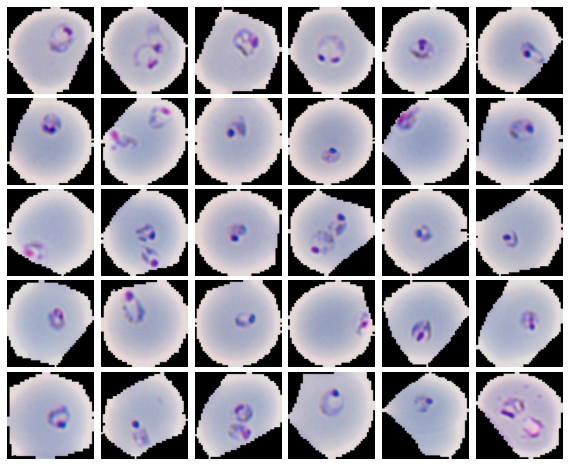

In [16]:
import matplotlib.image as mplimg
fig = plt.figure(figsize = (10,10))
gs1 = mpl.gridspec.GridSpec(6, 6)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

for idx, val in enumerate(df_train[df_train['label'] == 1]["img_path"][200:230]):
#     print (idx, val)
    ax = plt.subplot(gs1[idx])
    ax.axis("off")
    ax.set_aspect('equal')
    im = mplimg.imread(val)
    img_scaled = cv2.resize(im, (224, 224), interpolation = cv2.INTER_AREA)
    ax.imshow(img_scaled)

In [12]:
class MalariaDataset(Dataset):
    def __init__(self, data, transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_path,label = self.data[index]
        image = Image.open(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [63]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
#         transforms.RandomCrop((224, 224)),
        torchvision.transforms.ColorJitter(
            brightness = 0.1, 
            contrast =   0.1,
            saturation = 0.1, 
            hue = 0.5
        ),
        torchvision.transforms.RandomHorizontalFlip( p = 0.5),
        torchvision.transforms.RandomRotation(degrees=(-90, 90), resample = Image.BILINEAR),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
#         transforms.CenterCrop((224, 224)),
#                 torchvision.transforms.ColorJitter(contrast =   (1.45,1.5) ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [68]:
# Set fixed random number seed
torch.manual_seed(42)
train_data, valid_data = train_test_split(df_train[["img_path", "label"]], stratify=df_train["label"], test_size=0.25)
image_datasets =  { "train" : MalariaDataset(train_data, data_transforms["train"]), 
                     "valid": MalariaDataset(valid_data, data_transforms["valid"]) }
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

batch_size = 32
dataloaders = {"train": DataLoader(dataset = image_datasets["train"], batch_size = batch_size, shuffle=True, num_workers=0), 
              "valid": DataLoader(dataset = image_datasets["valid"], batch_size = batch_size, shuffle=False, num_workers=0)}

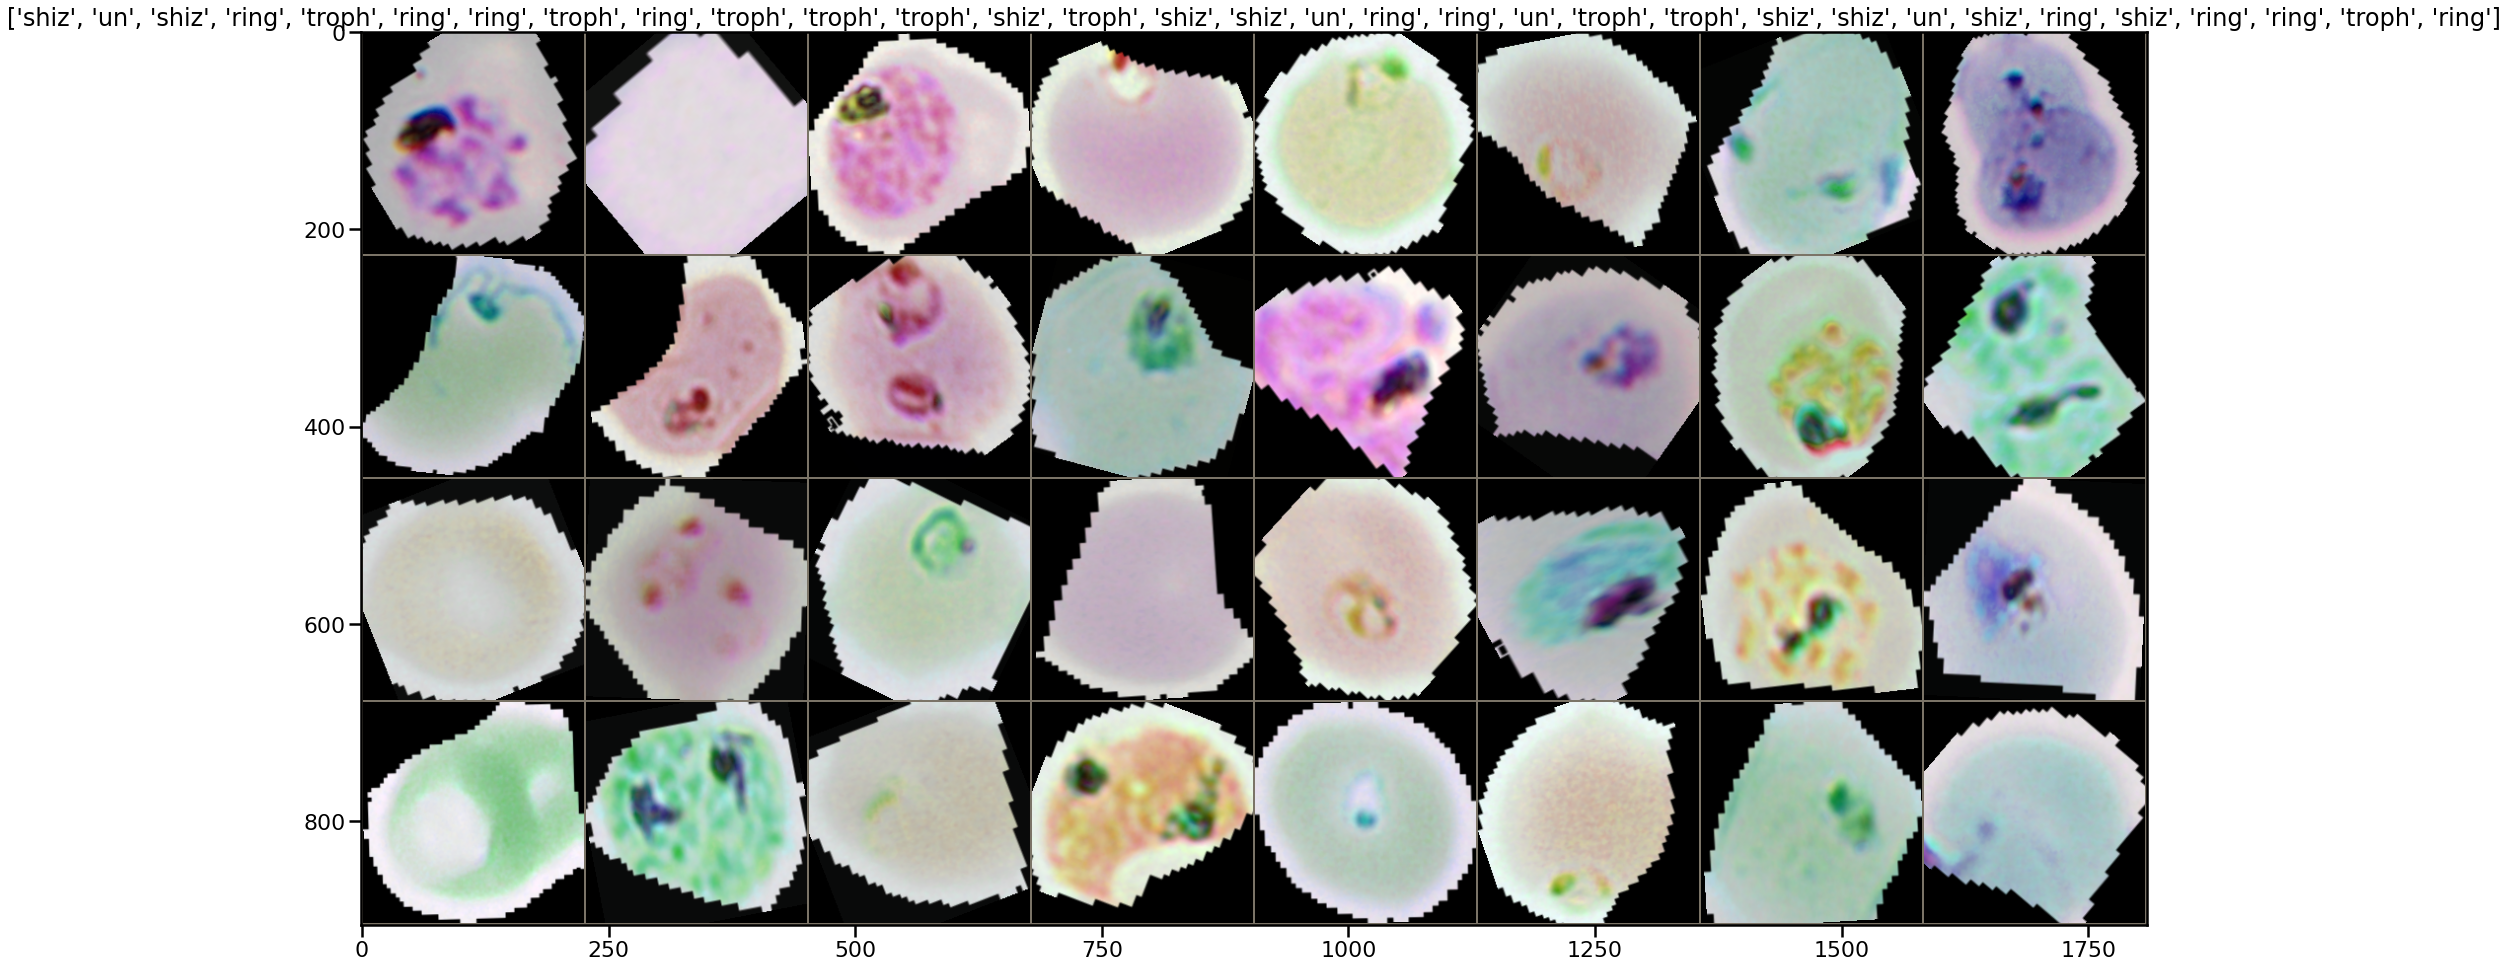

In [71]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

fig = plt.figure(figsize = (32, 32))
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))
class_name_ls = ["un", 'ring', 'troph', 'shiz']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_name_ls[x] for x in classes.int()])

In [72]:
add2log(data_transforms)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    since = time.time()
    s = ""
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    out = { 'train': { },  
             'valid': { }} 
    
    for epoch in range(num_epochs):
        s = 'Epoch {}/{}'.format(epoch, num_epochs - 1)
        print(s)
        add2log(s)
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            out[phase][epoch] = [epoch_loss, epoch_acc.cpu().detach().numpy()]
            
            
            s = '{} Loss: {:.4f} | Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc)
            print (s)
            add2log(s)

            
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

     

    time_elapsed = time.time() - since
    s = 'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60)
    print (s)
    add2log(s)
    s = 'Best val Acc: {:4f}'.format(best_acc)
    print (s)
    add2log(s)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, out

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
#                 ax = fig.add_subplot(num_images//2, 3, images_so_far)
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
     

In [47]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_name_ls))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
add2log("Number of trainable params: " + count_parameters(model_ft))

In [51]:

model_ft, out = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs = EPOCHS)

Epoch 0/0
----------
train Loss: 0.5414 Acc: 0.8026
val Loss: 0.7969 Acc: 0.7159

Training complete in 0m 30s
Best val Acc: 0.715877


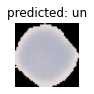

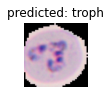

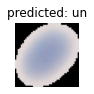

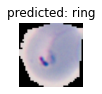

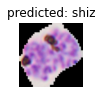

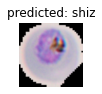

In [360]:
visualize_model(model_ft)


In [248]:
model_ft.training

False

### ConvNet as fixed feature extractor

In [74]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_name_ls))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(filter(lambda p: p.requires_grad, model_conv.parameters()), lr = 0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
add2log("Number of trainable params: " + str(count_parameters(model_conv)))
add2log('*'*10)

In [75]:
# model_conv = model_conv.to(device)
# model_sum = summary(model_conv)
# add2log(str(model_sum))
model_conv, out = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs = 15)

Epoch 0/14
----------
train Loss: 0.9667 | Acc: 0.6021
valid Loss: 0.7250 | Acc: 0.6985
Epoch 1/14
----------
train Loss: 0.6779 | Acc: 0.7459
valid Loss: 0.6360 | Acc: 0.7286
Epoch 2/14
----------
train Loss: 0.6059 | Acc: 0.7673
valid Loss: 0.5398 | Acc: 0.7859
Epoch 3/14
----------
train Loss: 0.5806 | Acc: 0.7791
valid Loss: 0.4818 | Acc: 0.8211
Epoch 4/14
----------
train Loss: 0.5280 | Acc: 0.8029
valid Loss: 0.4578 | Acc: 0.8201
Epoch 5/14
----------
train Loss: 0.5111 | Acc: 0.7985
valid Loss: 0.4856 | Acc: 0.8030
Epoch 6/14
----------
train Loss: 0.5101 | Acc: 0.8046
valid Loss: 0.4586 | Acc: 0.8241
Epoch 7/14
----------
train Loss: 0.4653 | Acc: 0.8284
valid Loss: 0.4285 | Acc: 0.8362
Epoch 8/14
----------
train Loss: 0.4748 | Acc: 0.8237
valid Loss: 0.4257 | Acc: 0.8362
Epoch 9/14
----------
train Loss: 0.4884 | Acc: 0.8150
valid Loss: 0.4433 | Acc: 0.8241
Epoch 10/14
----------
train Loss: 0.4613 | Acc: 0.8257
valid Loss: 0.4227 | Acc: 0.8372
Epoch 11/14
----------
train Lo

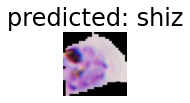

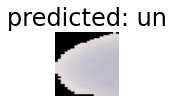

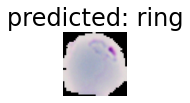

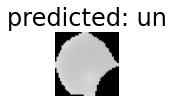

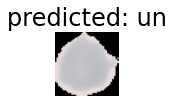

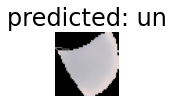

In [317]:
visualize_model(model_conv)

### Fine-tuning of the convnet

In [94]:
optimizer_conv

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [76]:
# unfreeze top layers of convent
# note: firstly train head of the net
curr_layer = 0
layer_to_unfreeze = 7
for child in model_conv.children():
    curr_layer+=1
    if curr_layer >= layer_to_unfreeze:
        for param in child.parameters():
            param.requires_grad = True
        print ("child", child)
#         add2log(child)


add2log("Number of trainable params: " + str(count_parameters(model_conv)))


child Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256,

In [226]:
summary(model_conv)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  (36,864)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  (36,864)
|    |    └─BatchNorm2d: 3-5             (128)
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  (36,864)
|    |    └─BatchNorm2d: 3-7             (128)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (36,864)
|    |    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 (73,728)
|    |    └─BatchNorm

In [77]:
# fine tuning should improve accuracy
optimizer_conv = optim.Adam(filter(lambda p: p.requires_grad, model_conv.parameters()))
model_conv_tun, out_tun = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs = 30)

Epoch 0/29
----------
train Loss: 0.4888 | Acc: 0.8418
valid Loss: 0.2548 | Acc: 0.9106
Epoch 1/29
----------
train Loss: 0.2684 | Acc: 0.9051
valid Loss: 0.6727 | Acc: 0.7508
Epoch 2/29
----------
train Loss: 0.2270 | Acc: 0.9149
valid Loss: 0.1944 | Acc: 0.9276
Epoch 3/29
----------
train Loss: 0.2342 | Acc: 0.9108
valid Loss: 0.2674 | Acc: 0.8955
Epoch 4/29
----------
train Loss: 0.2164 | Acc: 0.9216
valid Loss: 0.2318 | Acc: 0.9216
Epoch 5/29
----------
train Loss: 0.2121 | Acc: 0.9249
valid Loss: 0.1984 | Acc: 0.9236
Epoch 6/29
----------
train Loss: 0.2016 | Acc: 0.9246
valid Loss: 0.1832 | Acc: 0.9327
Epoch 7/29
----------
train Loss: 0.1839 | Acc: 0.9400
valid Loss: 0.1623 | Acc: 0.9427
Epoch 8/29
----------
train Loss: 0.1715 | Acc: 0.9340
valid Loss: 0.2047 | Acc: 0.9106
Epoch 9/29
----------
train Loss: 0.1903 | Acc: 0.9336
valid Loss: 0.1706 | Acc: 0.9407
Epoch 10/29
----------
train Loss: 0.1685 | Acc: 0.9370
valid Loss: 0.1946 | Acc: 0.9256
Epoch 11/29
----------
train Lo

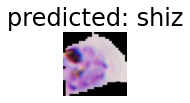

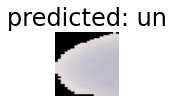

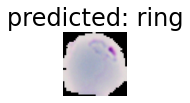

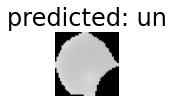

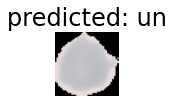

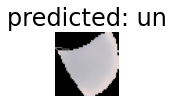

In [320]:
visualize_model(model_conv_tun)

### Save the model

In [333]:
# path_model = r"C:\Users\AChub_Lab\Desktop\my_project"
torch.save(model_conv_tun.state_dict(), "resnet18_fc-ep25_topblock8-ep40.pth")

In [93]:
torch.save(model_conv_tun, "resnet18_tun_coloraug.pth")

In [33]:
model_conv.load_state_dict(torch.load("resnet18_fc-ep25_topblock8-ep40.pth"))

<All keys matched successfully>

### Test the models

In [34]:
test_path = r"C:\Users\AChub_Lab\Desktop\my_project\cell_images\cell_images"
matches = []
for root, dirnames, filenames in os.walk(test_path):
    for filename in filenames:
        if filename.endswith(('.png', ".PNG")):
#             print (filename)
            matches.append(os.path.join(root, filename))
print (len(matches))

27545


In [35]:
df_test = pd.DataFrame(matches, columns = ["img_path"])
stage = df_test["img_path"].str.split("\\", expand = True)[7]
df_test.loc[:, "stage"] = stage

def add_label(row):
    if row['stage'] == "Parasitized":
        return 1
    if row['stage'] == 'Uninfected':
        return 0
    return 'Other'
df_test.loc[:, "label"] = df_test.apply (lambda row: add_label(row), axis=1)

df_test.head()

,img_path,stage,label
0,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1
1,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1
2,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1
3,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1
4,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1


In [36]:
df_test.groupby("label").count()

,img_path,stage
label,,
0,13779,13779
1,13766,13766


In [36]:
# create a list of our conditions
conditions = [
#     (df['folder'].str.contains("un")), 
    (df_test['stage'] == "R"),
    (df_test['stage'] == "T"),
#     (df['ts'] > 9) & (df['ts'] <= 15),
    (df_test['stage'] == "S")
    ]

# create a list of the values we want to assign for each condition
# values = ["un", 'ring', 'troph', 'shiz']
values = np.arange(1, 4)
# create a new column and use np.select to assign values to it using our lists as arguments
df_test['label'] = np.select(conditions, values)

KeyError: 'stage'

In [38]:
test_dataset =  MalariaDataset(df_test[["img_path", "label"]], data_transforms["valid"])
                     
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
batch_size = 512
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)

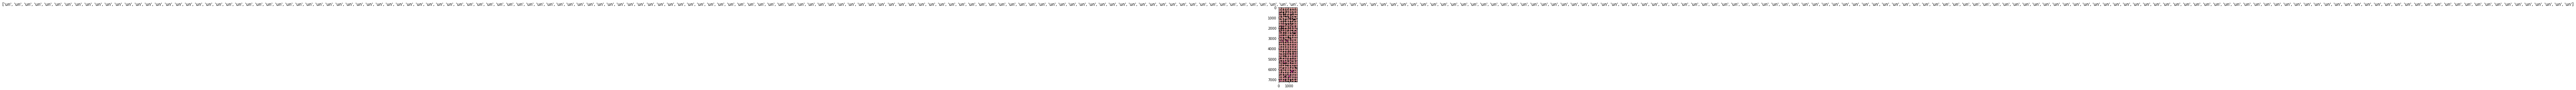

In [61]:
inputs, classes = next(iter(test_loader))
class_names = ["un", 'ring', 'troph', 'shiz']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [78]:
# test-the-model
model = model_conv_tun
all_preds = []
test_labels = []
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted = predicted.cpu().numpy()
       
        labels = labels.cpu().numpy()
        all_preds.append(predicted)
        test_labels.append(labels)
        
        predicted_clip = np.clip(predicted, 0, 1)
        total += labels.size
        correct += (predicted_clip == labels).sum().item()
        
#         false_idx = ((predicted == labels) == 0).nonzero()
#         if len(false_idx) > 0:
#             print (predicted[false_idx].flatten())
#             print (labels[false_idx].flatten())
    s = 'Test Accuracy of the model: {:.4f} %'.format(100 * correct / total)
    print (s)
    add2log(s)
# Save 
# torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 91.5774 %


In [91]:
df_test.shape

(27545, 4)

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_context("poster")

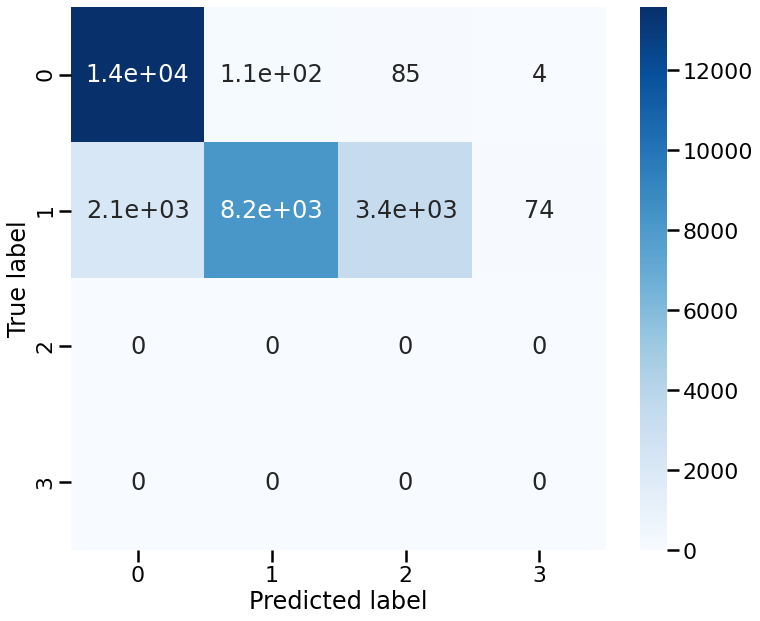

In [92]:
cm = confusion_matrix(np.concatenate(test_labels), np.concatenate(all_preds))
fig = plt.figure(figsize = (12,10))
sns.heatmap(cm, annot = True, cmap = "Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig("confusion_matrix.png")

In [86]:
preds = np.concatenate(all_preds)
df_test.loc[:, "preds"] = preds

108


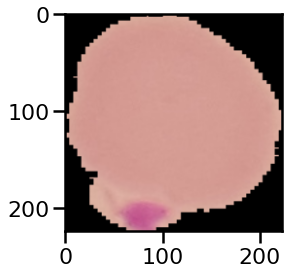

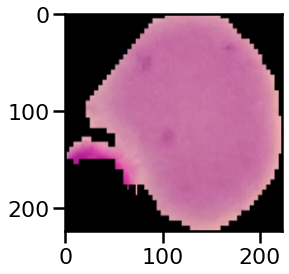

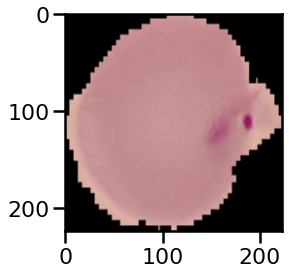

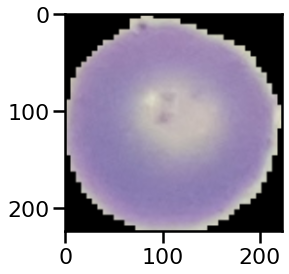

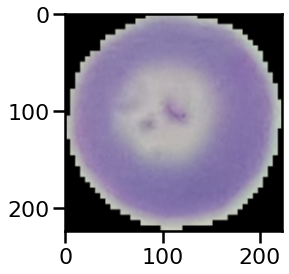

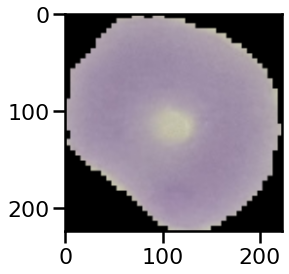

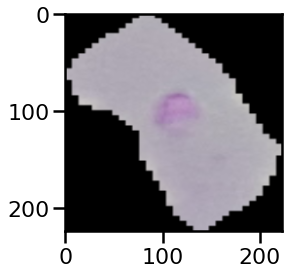

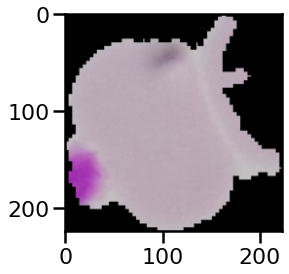

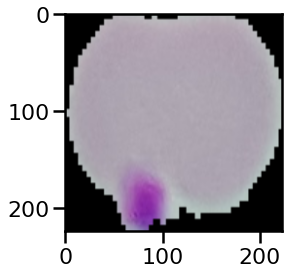

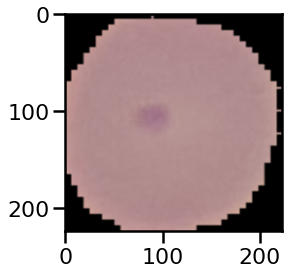

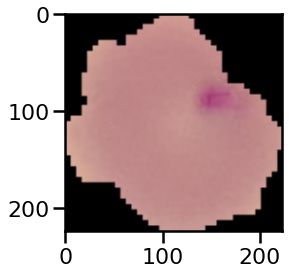

In [90]:
img_list = df_test[(df_test.preds == 1) & (df_test.label == 0)].img_path
print (len(img_list))
for fname in img_list[::10]:
    im = plt.imread(fname)
    im = cv2.resize(im, (224,224))
    plt.imshow(im)
    plt.show()
    

In [84]:
df_test[(df_test.preds == 3) & (df_test.label == 1)]

,img_path,stage,label,preds
21,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1,3
36,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1,3
37,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1,3
43,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1,3
51,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1,3
...,...,...,...,...
13691,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1,3
13695,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1,3
13746,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1,3
13748,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1,3


In [49]:
from sklearn.model_selection import KFold

In [107]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

{'train': {0: [0.683567347911727, tensor(0.7401, dtype=torch.float64)]},
 'val': {0: [0.588532634151792, tensor(0.7900, dtype=torch.float64)]}}

### Convnet cross-validation 

In [114]:
# Set fixed random number seed
torch.manual_seed(42)
batch_size = 64
num_epochs = 25
k_folds = 5
dataset = df[["img_path", "label"]]

kfold = KFold(n_splits=k_folds, shuffle=True)
results = {}


for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
#     print (fold, len(train_ids) , len(test_ids))
    image_datasets = {}
    dataloaders = {}
    print(f'FOLD {fold}')
    print('||||||||||||')
    
    image_datasets =  { "train" : MalariaDataset(dataset.loc[train_ids], data_transforms["train"]), 
                         "val": MalariaDataset(dataset.loc[test_ids], data_transforms["val"]) }
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    dataloaders = {"train": DataLoader(dataset = image_datasets["train"], batch_size = batch_size, shuffle=True, num_workers=0), 
                  "val": DataLoader(dataset = image_datasets["val"], batch_size = batch_size, shuffle=False, num_workers=0)}

    model_conv = torchvision.models.resnet18(pretrained=True)
    
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, len(class_names))
    model_conv = model_conv.to(device)
    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized as
    # opposed to before.
    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
    
    model_conv, results[fold] = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs = num_epochs)

    # Saving the model
#     save_path = f'./model-fold-{fold}.pth'
#     torch.save(network.state_dict(), save_path)
    

FOLD 0
--------------------------------
Epoch 0/24
----------
train Loss: 1.2168 Acc: 0.4367
val Loss: 0.9473 Acc: 0.6092

Epoch 1/24
----------
train Loss: 0.8866 Acc: 0.6502
val Loss: 0.8190 Acc: 0.6881

Epoch 2/24
----------
train Loss: 0.8096 Acc: 0.6842
val Loss: 0.7359 Acc: 0.7427

Epoch 3/24
----------
train Loss: 0.7812 Acc: 0.7063
val Loss: 0.7078 Acc: 0.7464

Epoch 4/24
----------
train Loss: 0.7619 Acc: 0.7073
val Loss: 0.6840 Acc: 0.7597

Epoch 5/24
----------
train Loss: 0.7400 Acc: 0.7194
val Loss: 0.6557 Acc: 0.7621

Epoch 6/24
----------
train Loss: 0.7196 Acc: 0.7297
val Loss: 0.6611 Acc: 0.7597

Epoch 7/24
----------
train Loss: 0.7047 Acc: 0.7376
val Loss: 0.6558 Acc: 0.7597

Epoch 8/24
----------
train Loss: 0.7071 Acc: 0.7282
val Loss: 0.6503 Acc: 0.7621

Epoch 9/24
----------
train Loss: 0.6989 Acc: 0.7391
val Loss: 0.6577 Acc: 0.7585

Epoch 10/24
----------
train Loss: 0.7088 Acc: 0.7264
val Loss: 0.6573 Acc: 0.7609

Epoch 11/24
----------
train Loss: 0.7092 Acc:

KeyboardInterrupt: 